In [1]:
import sys

import astropy.units as u
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
import seaborn as sns
import yaml
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.estimators import FluxPoints
from gammapy.modeling import Parameter, Parameters
from gammapy.modeling.models import FoVBackgroundModel, Models
from matplotlib import rc
from scipy.interpolate import interp2d

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


(None, <pyximport.pyximport.PyxImporter at 0x7fc65c42f1f0>)

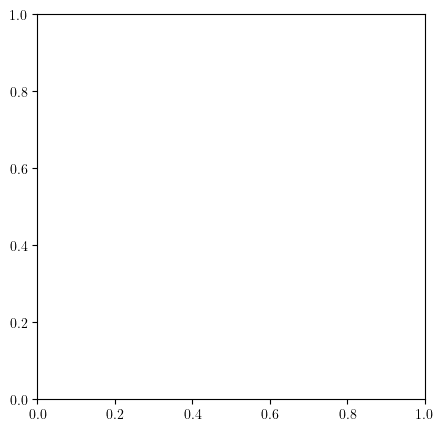

In [2]:
savefig = 1
picformat = "png"
fig, a_fake = plt.subplots(1, 1, figsize=(5.0, 5.0))

## Methods


In [3]:
def compute_fraction(Ls_new, x_new, y_new, threshold, plot=False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    inside = Ls_new * (Ls_new >= offset)
    fraction_inside = np.sum(inside) / tot_int
    if plot:
        fig, ax = plt.subplots(
            1,
            1,
        )
        im = ax.pcolormesh(x_new, y_new, Ls_new)
        fig.colorbar(im)
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        ax.contour(
            x_new, y_new, Ls_new, colors=("gold",), levels=[Ls_new.min() + threshold]
        )
    return fraction_inside


def plot_L(
    Ls_new,
    x_new,
    y_new,
    threshold,
    find_min,
    color="red",
    ax=None,
    fig=None,
    cbar=True,
    cmap="viridis",
):
    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min=find_min
    )
    if ax is None:
        fig, ax = plt.subplots(
            1,
            1,
        )

    im = ax.pcolormesh(x_new, y_new, Ls_new, cmap=cmap, rasterized=True)
    if cbar:
        fig.colorbar(im)

    CS = ax.contour(
        x_new, y_new, Ls_new, colors=(color,), levels=[Ls_new.min() + threshold]
    )
    # ax.clabel(CS, CS.levels, inline=True, fmt='$1\\sigma$', fontsize=12)

    plot_errors(
        ax,
        x_new,
        y_new,
        index_min,
        index_max,
        ampli_min,
        ampli_max,
        index_best,
        ampli_best,
        color,
    )

    ax.plot(ampli_best, index_best, "x", color=color)

    ax.set_ylabel(f"Amplitude [{a_unit}]")
    ax.set_xlabel("Index []")
    return CS


def plot_errors(
    ax,
    x_new,
    y_new,
    index_min,
    index_max,
    ampli_min,
    ampli_max,
    index_best,
    ampli_best,
    color,
):
    linewidth = 2

    ax.hlines(
        y=index_min,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.hlines(
        y=index_max,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )

    ax.vlines(
        x=ampli_min,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.vlines(
        x=ampli_max,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )


def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best


def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim)
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)

    return np.count_nonzero(is_within) / len(data)

In [4]:
def plot_amplitude(axs_a):
    # ampli
    a = axs_a
    i = 1
    a.hist(
        valuies[i][1:, 0],
        color=color_rnd,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
        orientation="horizontal",
    )

    a.hist(
        valuies_N[i][1:, 0],
        color=color_rnd_nui,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
        orientation="horizontal",
    )

    ylim = a.get_xlim()
    delta_ylim = 5
    a.hlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    a.fill_betweenx(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=alpha_nui,
        color=colors[3],
        label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
    )
    a.hlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    a.fill_betweenx(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=alpha_st,
        color=colors[2],
        label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
    )
    a.set_xlabel("")
    a.set_ylim(axs_L.get_ylim()[0], axs_L.get_ylim()[1])
    yy = a.get_xlim()[1]
    print(
        f"amplitudes  : {np.mean(amplitudes[:,0]):.5} pm {np.std(amplitudes[:,0]):.5}"
    )
    print(
        f"amplitudes N: {np.mean(amplitudes_N[:,0]):.5} pm {np.std(amplitudes_N[:,0]):.5}"
    )

    a.errorbar(
        x=yy / 3,
        y=np.mean(amplitudes[:, 0]),
        yerr=np.std(amplitudes[:, 0]),
        fmt="o",
        color=color_rnd_err,
        label="",
    )

    a.errorbar(
        x=yy / 3 - y2,
        y=np.mean(amplitudes_N[:, 0]),
        yerr=np.std(amplitudes_N[:, 0]),
        fmt="o",
        color=color_rnd_nui_err,
        label="",
    )

    a.set_yticklabels([])
    a.set_yticks([])


def plot_index(axs_i):
    # index
    a = axs_i
    i = 2
    a.hist(
        valuies[i][1:, 0],
        color=color_rnd,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
    )
    a.hist(
        valuies_N[i][1:, 0],
        color=color_rnd_nui,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
    )
    ylim = a.get_ylim()
    delta_ylim = 5
    a.vlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    a.fill_between(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=alpha_nui,
        color=colors[3],
        label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
    )
    a.vlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    a.fill_between(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=alpha_st,
        color=colors[2],
        label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
    )
    a.set_xlabel(xlabels[i])
    yy = a.get_ylim()[1]
    print(f"index     : {np.mean(indices[:,0]):.5} pm {np.std(indices[:,0]):.5}")
    print(f"index nui : {np.mean(indices_N[:,0]):.5} pm {np.std(indices_N[:,0]):.5}")
    a.errorbar(
        x=np.mean(indices[:, 0]),
        y=yy / 3,
        xerr=np.std(indices[:, 0]),
        fmt="o",
        color=color_rnd_err,
        label="",
    )
    a.errorbar(
        x=np.mean(indices_N[:, 0]),
        y=yy / 3 - y2,
        xerr=np.std(indices_N[:, 0]),
        fmt="o",
        color=color_rnd_nui_err,
        label="",
    )
    a.set_xlim(axs_L.get_xlim()[0], axs_L.get_xlim()[1])
    a.set_xlabel("")
    a.set_xticklabels([])
    a.set_xticks([])


def plot_randoms(axs_L, fig):
    (
        ampli_min_asimov_N,
        ampli_max_asimov_N,
        index_min_asimov_N,
        index_max_asimov_N,
        ampli_best_asimov_N,
        index_best_asimov_N,
    ) = compute_errors(
        data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
    )

    CS_N = plot_L(
        data_contour_N,
        indexy__new_N,
        amplix__new_N,
        threshold_contour,
        find_min=True,
        color=colors[1],
        ax=a_fake,
        fig=fig,
        cbar=False,
        cmap=cmap,
    )
    dat_N = CS_N.allsegs[0][0]
    axs_L.plot(dat_N[:, 0], dat_N[:, 1], color=colors[1])

    CS = plot_L(
        data_contour,
        indexy__new,
        amplix__new,
        threshold_contour,
        find_min=True,
        color=colors[1],
        ax=a_fake,
        fig=fig,
        cbar=False,
        cmap=cmap,
    )
    dat = CS.allsegs[0][0]
    axs_L.plot(dat[:, 0], dat[:, 1], color=colors[0])
    # axs_L.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[0])

    axs_L.scatter(
        indices_data_N,
        amplitudes_data_N,
        marker=".",
        color=color_rnd_nui,
        alpha=alpha_rnd_nui,
        label="Rnd with nui.",
    )
    axs_L.scatter(
        indices_data,
        amplitudes_data,
        marker="x",
        s=14,
        color=color_rnd,
        alpha=alpha_rnd,
        label="Rnd w/o nui.",
    )

    model = fluxpoints_ds.models[0]
    ampli, index = model.parameters["amplitude"].value, model.parameters["index"].value
    ampli_err, index_err = (
        model.parameters["amplitude"].error,
        model.parameters["index"].error,
    )
    axs_L.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="x",
        markersize=6,
        color=color_rnd_example,
        alpha=0.99,
        label="Example w/o nui.",
    )

    model = fluxpoints_Nds.models[0]
    ampli, index = model.parameters["amplitude"].value, model.parameters["index"].value
    ampli_err, index_err = (
        model.parameters["amplitude"].error,
        model.parameters["index"].error,
    )

    axs_L.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="o",
        markersize=6,
        color=color_rnd_nui_example,
        alpha=0.99,
        label="Example with nui.",
    )

    axs_L.plot(2.3, 1e-12, "^", markersize=6, color="black", label="Input")
    axs_L.plot(2.3, 1e-12, "x", markersize=8, color=colors[1], label=legendsscatter[1])
    axs_L.plot(2.3, 1e-12, "+", markersize=10, color=colors[0], label=legendsscatter[0])

    off = 1e-14
    axs_L.text(
        index_best_asimov_N,
        off + ampli_max_asimov_N,
        "$1\\sigma$",
        color=colors[1],
        fontsize="x-large",
    )
    axs_L.text(
        index_best_asimov_N,
        off + ampli_max_asimov,
        "$1\\sigma$",
        color=colors[0],
        fontsize="x-large",
    )
    axs_L.plot(
        [np.nan, np.nan],
        [np.nan, np.nan],
        alpha=1,
        color=colors[0],
        label=legends[0],
    )  # + f'{fraction_N:.3}\\%')
    axs_L.plot(
        [np.nan, np.nan],
        [np.nan, np.nan],
        alpha=1,
        color=colors[1],
        label=legends[1],
    )  # +  f'{fraction:.3}\\%'  )
    axs_L.legend(ncol=2)
    axs_L.set_xlabel("Index []")
    axs_L.set_ylabel("Amplitude [1/cm2 s TeV]")

    # plt.tight_layout()
    if savefig:
        fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS_nui." + picformat)
        fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS_nui." + "png")
    print(N)
    return fig


def plot_choice_sed(fig, ax):
    fluxpoints_ds.data.plot(
        energy_power=2,
        ax=ax,
        color=color_rnd_example,
        label="Example w/0 nui.",
        marker="x",
    )
    fluxpoints_Nds.data.plot(
        energy_power=2, ax=ax, color=color_rnd_nui_example, label="Example with nui."
    )

    model = fluxpoints_ds.models[0]
    info = f"$\\phi_0$={model.parameters['amplitude'].value:.2} $\\pm$"
    info += f"{model.parameters['amplitude'].error:.2}\n  {model.parameters['amplitude'].unit}"
    info += f"\n$\\Gamma$={model.parameters['index'].value:.2} $\\pm$"
    info += f"{model.parameters['index'].error:.2}  {model.parameters['index'].unit}"
    fluxpoints_ds.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=color_rnd_example,
        label="",
    )
    fluxpoints_ds.models[0].spectral_model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=color_rnd_example,
        label="",
        alpha=0.3,
    )

    model = fluxpoints_Nds.models[0]
    info = f"$\\phi_0$={model.parameters['amplitude'].value:.2} $\\pm$"
    info += f"{model.parameters['amplitude'].error:.2}\n  {model.parameters['amplitude'].unit}"
    info += f"\n$\\Gamma$={model.parameters['index'].value:.2} $\\pm$"
    info += f"{model.parameters['index'].error:.2}  {model.parameters['index'].unit}"
    fluxpoints_Nds.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=color_rnd_nui_example,
        label="",
        linestyle="dashed",
    )
    fluxpoints_Nds.models[0].spectral_model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=color_rnd_nui_example,
        label="",
        alpha=0.3,
    )

    ax.set_title(f"Bias: {shift_rnd*100:.3} \\%; Resolution: {tilt_rnd*100:.3}\\% ")
    model = dataset_asimov.models[0]
    info = f"$\\phi_0$={model.parameters['amplitude'].value:.2}\n "
    info += f"{model.parameters['amplitude'].unit}"
    info += f"\n$\\Gamma$={model.parameters['index'].value:.2} "
    info += f"{model.parameters['index'].unit}"
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )
    # ax.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.6), ncol = 3)
    ax.legend(loc="lower left")

    # ax.legend()
    # plt.tight_layout()
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-13, 2e-12)


def plot_rnd_fistribution(fig, ax, cc):
    nbins = 30
    count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color="grey")
    sigma = shift
    mu = 0
    axs.plot(
        bins,
        1
        / (sigma * np.sqrt(2 * np.pi))
        * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
        linewidth=2,
        color="black",
        label=f"$\\mu = {mu}; \\sigma = {sigma}$",
    )

    axs.vlines(
        shift_rnd,
        0,
        axs.get_ylim()[1],
        color=cc,
        label=f"Example value: {shift_rnd*100:.2} \\%",
    )

    axs.set_xlabel("Systematic on Eff. Area Norm [\\%]")
    axs.legend(loc="center right")

    x = axs.get_xlim()
    deltax = np.max([mu - x[0], x[1] - mu])
    axs.set_xlim(mu - deltax, mu + deltax)

    count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color="grey")
    sigma = tilt
    mu = 0
    ax1.plot(
        bins,
        1
        / (sigma * np.sqrt(2 * np.pi))
        * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
        linewidth=2,
        color="black",
        label=f"$\\mu = {mu}; \\sigma = {sigma:.3}$",
    )
    ax1.vlines(
        tilt_rnd,
        0,
        ax1.get_ylim()[1],
        color=cc,
        label=f"Example value {tilt_rnd*100:.2} \\%",
    )

    ax1.set_xlabel("Systematic on Eff. Area Tilt [\\%]")
    # ax1.set_title(f"N = {N}")
    ax1.legend(loc="center right")

    x = ax1.get_xlim()
    deltax = np.max([mu - x[0], x[1] - mu])
    ax1.set_xlim(mu - deltax, mu + deltax)
    plt.tight_layout()


def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-13, 2e-12)


def plot_coverage(fig, ax2):
    p = compute_precision(N)
    ax2.errorbar(ebins, withine, yerr=p, color=colors[0], label="")
    ax2.errorbar(ebins * 1.05, withine_N, yerr=p, color=colors[1], label="")
    ax2.plot(ebins, [0.68] * len(ebins), ":", color="black", label="")
    # ax2.legend(ncol = 2)
    axs.set_title(f"N = {N} (p = {p*100:.3}\\%)")
    ax2.set_xlabel("Energy [TeV]")
    ax2.set_ylabel("Coverage")
    axs.set_xlabel("")
    plt.tight_layout()

## Import

### Datasets

In [5]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1 / 60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

shift = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.1

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_input = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / bias**2, 1 / resolution**2, 1 / zero**2, 1 / zero**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["resolution"].frozen = False
dataset_asimov_N.irf_model.parameters["bias"].frozen = False


a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

datasets = Datasets(dataset_asimov)
datasets_N = Datasets(dataset_asimov_N)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [6]:
m = Models.read("data/1_model.yml")
dataset_asimov.models = Models(
    [
        m[0],
        FoVBackgroundModel(dataset_name=dataset_asimov.name),
    ]
)
path = "data/1_model_N.yml"
dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
dataset_asimov_N.models.parameters["tilt_nuisance"].frozen = False

### Fluxpoints

In [8]:
fp_asimov = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/6_fluxpoints_asimov.fits"),
    models=Models.read("data/fluxpoints/6_model_asimov.fits"),
)
fp_asimov_N = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/6_fluxpoints_asimov_N.fits"),
    models=Models.read("data/fluxpoints/6_model_asimov_N.fits"),
)

### Results

In [9]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
stat_sums = infos[:N_max, 2]


# amplitude', 'index', 'lambdas', 'norm', 'tilt
amplitudes = pars[:N_max, 0:2]
indices = pars[:N_max, 2:4]
lambdas = pars[:N_max, 4:6]
norms = pars[:N_max, 6:8]
tilts = pars[:N_max, 8:10]

valuies = [norms, amplitudes, indices, lambdas]

24


In [10]:
pars_N = np.loadtxt("data/7a_N_P_draw_par.txt")
flux_N = np.loadtxt("data/7a_N_P_draw_flux.txt")
flux2e_N = np.loadtxt("data/7a_N_P_draw_flux2e.txt")


lem = len(pars_N)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
stat_sums = infos[:N_max, 2]


# amplitude', 'index', 'norm', 'tilt
amplitudes_N = pars_N[:N_max, 0:2]
indices_N = pars_N[:N_max, 2:4]
lambdas_N = pars_N[:N_max, 4:6]
norms_N = pars_N[:N_max, 6:8]
tilts_N = pars_N[:N_max, 8:10]
bias_N = pars_N[:N_max, 10:12]
resolution_N = pars_N[:N_max, 12:14]

valuies_N = [norms_N, amplitudes_N, indices_N, lambdas_N, bias_N, resolution_N]


amplitudes_data_N = valuies_N[1][:, 0]
indices_data_N = valuies_N[2][:, 0]
lambdas_data_N = valuies_N[3][:, 0]

22


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bias error: 0.339 pm 0.497
Resolution error: 0.394 pm 0.435


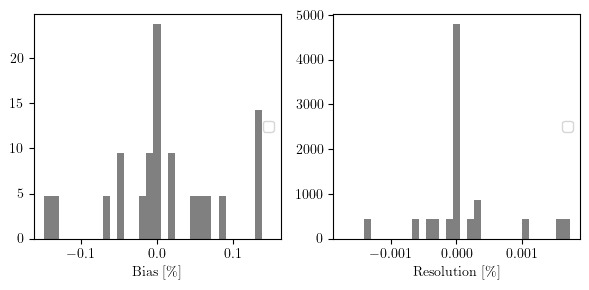

In [11]:
fig, (axs, ax1) = plt.subplots(1, 2, figsize=(6, 3))
nbins = 30
count, bins, ignored = axs.hist(bias_N[:, 0], nbins, density=True, color="grey")

axs.set_xlabel("Bias [\\%]")
axs.legend(loc="center right")

x = axs.get_xlim()
mu = 0
axs.set_xlim(mu - np.max(np.abs(x)), mu + np.max(np.abs(x)))

count, bins, ignored = ax1.hist(resolution_N[:, 0], nbins, density=True, color="grey")

ax1.set_xlabel("Resolution [\\%]")
# ax1.set_title(f"N = {N}")
ax1.legend(loc="center right")

x = ax1.get_xlim()
ax1.set_xlim(mu - np.max(np.abs(x)), mu + np.max(np.abs(x)))
plt.tight_layout()

print(f"Bias error: {np.mean(bias_N[:,1]):.3} pm {np.std(bias_N[:,1]):.3}")
print(
    f"Resolution error: {np.mean(resolution_N[:,1]):.3} pm {np.std(resolution_N[:,1]):.3}"
)

In [12]:
valuies_asimov = [
    [
        1,  # dataset_asimov.models[1].parameters['norm'].value,
        0,
    ],  # dataset_asimov.models[1].parameters['norm'].error],
    [
        dataset_asimov.models[0].parameters["amplitude"].value,
        dataset_asimov.models[0].parameters["amplitude"].error,
    ],
    [
        dataset_asimov.models[0].parameters["index"].value,
        dataset_asimov.models[0].parameters["index"].error,
    ],
    [
        dataset_asimov.models[0].parameters["lambda_"].value,
        dataset_asimov.models[0].parameters["lambda_"].error,
    ],
]


valuies_asimov_N = [
    [
        dataset_asimov_N.models.parameters["norm"].value,
        dataset_asimov_N.models.parameters["norm"].error,
    ],
    [
        dataset_asimov_N.models.parameters["amplitude"].value,
        dataset_asimov_N.models.parameters["amplitude"].error,
    ],
    [
        dataset_asimov_N.models.parameters["index"].value,
        dataset_asimov_N.models.parameters["index"].error,
    ],
    [
        dataset_asimov_N.models.parameters["lambda_"].value,
        dataset_asimov_N.models.parameters["lambda_"].error,
    ],
]
print(valuies_asimov_N)

[[1.0000006765879428, 0.0015651733188550912], [9.995187345469263e-13, 6.005766104854608e-14], [2.302256461533467, 0.15545538979911258], [0.01605690252107785, 0.014110129946867675]]


# Likelihood Contours

### Without Nuisance Parameters

In [13]:
with open("data/7c_contour.yml", "r") as stream:
    contour = yaml.safe_load(stream)
source = list(contour.keys())[0][:-24]
amplix__ = contour[f"{source}.spectral.amplitude_scan"]
indexy__ = contour[f"{source}.spectral.index_scan"]
N_new = 110
N_new_y = 100
amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)


f = interp2d(
    x=indexy__,
    y=amplix__,
    z=contour["stat_scan"],
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour = f(indexy__new, amplix__new)

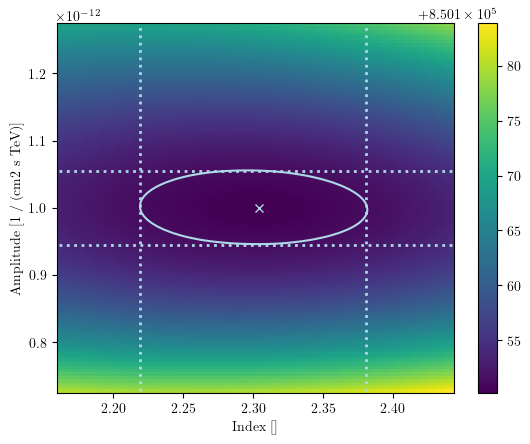

In [14]:
threshold_contour = 1

(
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
) = compute_errors(
    data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
)
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    threshold_contour,
    find_min=True,
    color="lightblue",
)

dat = CS.allsegs[0][0]

### With Nuisance Parameters

In [37]:

with open("data/7c_contour_N.yml", "r") as stream:
    contour_N = yaml.safe_load(stream)

# print(contour_N)
source_N = list(contour_N.keys())[0][:-24]

amplix___N = contour_N[f"{source_N}.spectral.amplitude_scan"]
indexy___N = contour_N[f"{source_N}.spectral.index_scan"]
amplix__new_N = np.linspace(amplix___N[0], amplix___N[-1], N_new)
indexy__new_N = np.linspace(indexy___N[0], indexy___N[-1], N_new_y)


f = interp2d(
    x=indexy___N,
    y=amplix___N,
    z=contour_N["stat_scan"],
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour_N = f(indexy__new_N, amplix__new_N)

FileNotFoundError: [Errno 2] No such file or directory: 'data/7c_contour_N.yml'

In [38]:
(
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
) = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
)

threshold_contour = 1

cmap = "plasma"
CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color="yellow",
    cmap=cmap,
)
ax = plt.gca()
dat_N = CS_N.allsegs[0][0]
ax.clabel(CS, CS.levels, inline=True, fmt="$1$", fontsize=12)
plt.plot(
    dat[:, 0],
    dat[:, 1],
    color="lightblue",
)
plot_errors(
    ax,
    indexy__new,
    amplix__new,
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
    "lightblue",
)
plt.plot(index_best_asimov_N, ampli_best_asimov_N, "x", color="yellow")
plt.plot(index_best_asimov, ampli_best_asimov, "x", color="lightblue")
fig = plt.gcf()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}." + picformat)

NameError: name 'data_contour_N' is not defined

## Compute fraction of within

In [39]:
# std best fit, nui best fit, ...
within_norm = [
    fraction_within(
        valuies_asimov[0][0] - valuies_asimov[0][1],
        valuies_asimov[0][0] + valuies_asimov[0][1],
        norms,
    ),
    fraction_within(
        valuies_asimov_N[0][0] - valuies_asimov_N[0][1],
        valuies_asimov_N[0][0] + valuies_asimov_N[0][1],
        norms,
    ),
    0.0,
    0.0,
]

within_amplitude = [
    fraction_within(
        valuies_asimov[1][0] - valuies_asimov[1][1],
        valuies_asimov[1][0] + valuies_asimov[1][1],
        amplitudes,
    ),
    fraction_within(
        valuies_asimov_N[1][0] - valuies_asimov_N[1][1],
        valuies_asimov_N[1][0] + valuies_asimov_N[1][1],
        amplitudes,
    ),
    fraction_within(ampli_min_asimov, ampli_max_asimov, amplitudes),
    fraction_within(ampli_min_asimov_N, ampli_max_asimov_N, amplitudes),
]

within_index = [
    fraction_within(
        valuies_asimov[2][0] - valuies_asimov[2][1],
        valuies_asimov[2][0] + valuies_asimov[2][1],
        indices,
    ),
    fraction_within(
        valuies_asimov_N[2][0] - valuies_asimov_N[2][1],
        valuies_asimov_N[2][0] + valuies_asimov_N[2][1],
        indices,
    ),
    fraction_within(index_min_asimov, index_max_asimov, indices),
    fraction_within(index_min_asimov_N, index_max_asimov_N, indices),
]

withins = [within_norm, within_amplitude, within_index]
print(withins)

NameError: name 'ampli_min_asimov_N' is not defined

In [40]:
mask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1) > 0
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
asimov, asimov_errors = dataset_asimov.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_asimov_N.models[0].spectral_model.evaluate_error(
    ebins
)

withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]
        lowerlim = np.all(value <= asimov.value[ie] + asimov_errors.value[ie])
        upperlim = np.all(value >= asimov.value[ie] - asimov_errors.value[ie])
        x = lowerlim & upperlim
        xs.append(x)

        lowerlim = np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie])
        upperlim = np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie])
        x = lowerlim & upperlim
        xs_N.append(x)

    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)

## 2D Histograms Poission

In [41]:
N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins)
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y)

amplitudes_data = valuies[1][:, 0]
indices_data = valuies[2][:, 0]
data_N_new, (abins, ibins) = np.histogramdd(
    (amplitudes_data, indices_data), (amplitude_bin, index_bin)
)
d_N = (data_contour_N < (1 + data_contour_N.min())).reshape(np.shape(data_contour_N))
d = (data_contour < (1 + data_contour.min())).reshape(np.shape(data_contour))
fraction = np.sum(data_N_new * d) / N * 100
fraction_N = np.sum(data_N_new * d_N) / N * 100

data_N_new, (abins, ibins) = np.histogramdd(
    (amplitudes_data, indices_data), (amplitude_bin, index_bin)
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

im = ax1.pcolormesh(ibins, abins, data_N_new * d)
im = ax2.pcolormesh(ibins, abins, data_N_new * d_N)

for ax in (ax1, ax2):
    ax.set_ylabel("Amplitudes")
    ax.set_xlabel("Indices")
    ax.plot(dat[:, 0], dat[:, 1], color="red")
    ax.plot(dat_N[:, 0], dat_N[:, 1], color="green")

ax1.set_title(f"Within $1\\sigma$ : {fraction:.3} \\%")
ax2.set_title(f"Within $1\\sigma$ Nuisance: {fraction_N:.3} \\%")

NameError: name 'amplix__new_N' is not defined

# End Plots

## Random Choice

In [28]:

s = sns.color_palette("Paired")
s

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [29]:
blue = "mediumblue", s[0]  # dark, light
green = s[3], s[2]
red = s[5], s[4]
orange = s[7], s[6]
purple = s[9], s[8]

print(s[0])

(0.6509803921568628, 0.807843137254902, 0.8901960784313725)


In [30]:
config = Dataset_load.load_config()
colors = config["colors"]["one"]

# asimov, asimov+nui, error asimov, error asimov+nui

a1 = blue
a2 = red
colors = [a1[0], a2[0], a1[1], a2[1]]

# rnd, rnd_example, error rnd_example, rnd+nui, rnd_example+nui, error rnd_example+nui
r1 = orange
r2 = purple
colors_rnd = [r1[0], r1[0], r1[0], r2[0], r2[0], r2[0]]

(
    color_rnd,
    color_rnd_example,
    color_rnd_err,
    color_rnd_nui,
    color_rnd_nui_example,
    color_rnd_nui_err,
) = colors_rnd
cc = color_rnd_example

alpha_nui = 0.99
alpha_st = 0.99
legendsscatter = ["Asimov w/o nui.", "Asimov with nui."]
legends = ["", ""]

alpha_rnd = 0.2
alpha_rnd_nui = 0.2

nbins = 20

/tmp/ipykernel_3185908/1046156222.py:387: RuntimeWarning: divide by zero encountered in double_scalars
  1
/tmp/ipykernel_3185908/1046156222.py:389: RuntimeWarning: divide by zero encountered in true_divide
  * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
/tmp/ipykernel_3185908/1046156222.py:387: RuntimeWarning: invalid value encountered in multiply
  1
/tmp/ipykernel_3185908/1046156222.py:415: RuntimeWarning: divide by zero encountered in double_scalars
  1
/tmp/ipykernel_3185908/1046156222.py:417: RuntimeWarning: divide by zero encountered in true_divide
  * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
/tmp/ipykernel_3185908/1046156222.py:415: RuntimeWarning: invalid value encountered in multiply
  1


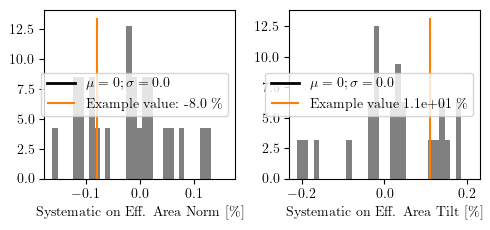

In [31]:

shift_rnd = -0.0796895
tilt_rnd = 0.110411

# shift_rnd  = random.choice(shift_rnds)
# tilt_rnd = random.choice(index_rnds)

fluxpoints = FluxPoints.read(
    f"data/fluxpoints/6_fluxpoints_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
)
fluxpoints_N = FluxPoints.read(
    f"data/fluxpoints/6_fluxpoints_N_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
)
model_name = f"data/fluxpoints/6_model_N_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
model_name = f"data/fluxpoints/6_model_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))

fig, (axs, ax1) = plt.subplots(1, 2, figsize=(5, 2.4))
plot_rnd_fistribution(fig, (axs, ax1), cc)
if savefig:
    fig.savefig(f"plots/7c_rnd_sys_{shift}." + picformat)
    fig.savefig(f"plots/7c_rnd_sys_{shift}.pdf")

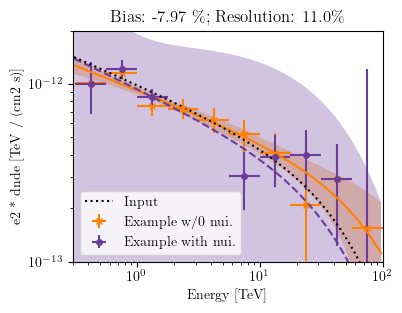

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_choice_sed(fig, ax)
fig.savefig("plots/7c_fluxpoint_example.pdf", bbox_inches="tight")
fig.savefig("plots/7c_fluxpoint_example.png", bbox_inches="tight")

NameError: name 'data_contour_N' is not defined

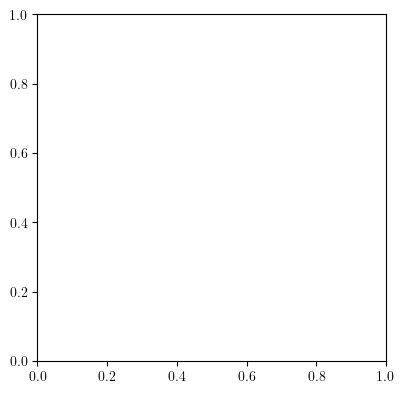

In [33]:
fig, axs_L = plt.subplots(1, 1, figsize=(4.5, 4.5))
fig = plot_randoms(axs_L, fig)
axs_L.set_ylim(0.65e-12, 1.35e-12)
axs_L.set_xlim(2.2, 2.4)

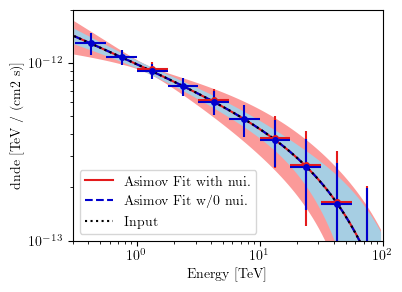

In [34]:
def compute_precision(N):
    Z = 1.645
    return Z / np.sqrt(N)


energy_power = 2
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
plot_asimov_spectrum(fig, axs)
fp_asimov_N.data.plot(energy_power=2, color=colors[1], ax=axs)
fp_asimov.data.plot(energy_power=2, color=colors[0], ax=axs)

axs.set_xlim(0.3, 100)
fig.savefig("plots/7c_asimov.pdf", bbox_inches="tight")
fig.savefig("plots/7c_asimov.png", bbox_inches="tight")

NameError: name 'data_contour_N' is not defined

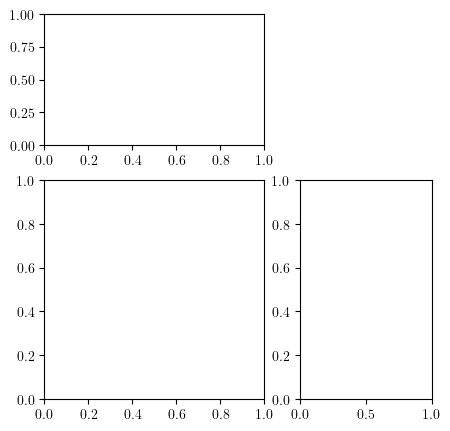

In [35]:
y2 = 2
fig, axs = plt.subplots(
    2,
    2,
    gridspec_kw={"height_ratios": [3, 5], "width_ratios": [5, 3]},
    figsize=(5.0, 5.0),
)
axs_L = axs[1][0]
axs_i = axs[0][0]
axs_a = axs[1][1]
axs[0, -1].axis("off")

fig = plot_randoms(axs_L, fig)
axs_L.set_ylim(0.7e-12, 1.3e-12)
axs_L.set_xlim(2.2, 2.4)

xlims = [None, amplix__new_N, indexy__new_N]
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]


plot_amplitude(axs_a)
plot_index(axs_i)


plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.08, hspace=0.08)
axs_L.legend(bbox_to_anchor=(1.2, 1.7))


# plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_nui." + picformat)
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_nui." + "png")
print(N)

NameError: name 'ebins' is not defined

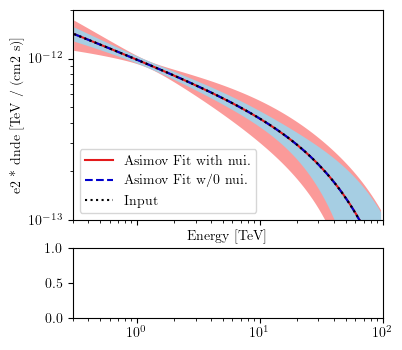

In [36]:
energy_power = 2
fig, (axs, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True, figsize=((4, 4))
)
plot_asimov_spectrum(fig, axs)
plot_coverage(fig, ax2)

## Input Within Rnd Results

In [24]:
a_within, i_within = [], []
a_within_N, i_within_N = [], []

a_input = dataset_asimov.models.parameters["amplitude"].value
i_input = dataset_asimov.models.parameters["index"].value

for a_ in amplitudes:
    a_within.append(((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input))
for i_ in indices:
    i_within.append(((i_[0] - i_[1]) <= i_input) and ((i_[0] + i_[1]) >= i_input))

for a_ in amplitudes_N:
    a_within_N.append(((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input))
for i_ in indices_N:
    i_within_N.append(((i_[0] - i_[1]) <= i_input) and ((i_[0] + i_[1]) >= i_input))

In [25]:
print(sum(a_within) / len(a_within))
print(sum(i_within) / len(i_within))

0.5416666666666666
0.4583333333333333


In [26]:
print(sum(a_within_N) / len(a_within_N))
print(sum(i_within_N) / len(i_within_N))

0.6818181818181818
0.6363636363636364
